## Algorithm functions

In [1]:
class Node:
    def __init__(self, value):
        self.value = value  # can be an operator or number
        self.left = None
        self.right = None

    def is_operator(self):
        return self.value in ["+", "-", "*", "/"]

    def evaluate(self):
        if not self.is_operator():
            return self.value
        left_val = self.left.evaluate()
        right_val = self.right.evaluate()
        if left_val is None:
          left_val = 0
        if right_val is None:
          right_val = 0
        if self.value == "+":
            return left_val + right_val
        elif self.value == "-":
            return left_val - right_val
        elif self.value == "*":
            return left_val * right_val
        elif self.value == "/":
            return left_val / right_val if right_val != 0 else None

    def __str__(self):
        return self.to_string()

    def to_string(self):
        if not self.is_operator():
            return str(self.value)

        left_str = self.left.to_string() if self.left else ""
        right_str = self.right.to_string() if self.right else ""

        # Apply parentheses to ensure correct order of operations
        if self.left.is_operator():
            left_str = f"({left_str})"
        if self.right and self.right.is_operator():
            right_str = f"({right_str})"

        return f"{left_str} {self.value} {right_str}"


In [2]:
import random

def random_tree(available_numbers, depth=0, max_depth=5, random_stop=True, desired_length=None):
    if desired_length is not None:
        if len(available_numbers) > desired_length:
            random.shuffle(available_numbers)
            available_numbers = available_numbers[:desired_length]
    # Base case: use a number if the maximum depth is reached or randomly decided to stop going deeper
    if depth >= max_depth or (random_stop and (depth > 0 and random.random() > 0.5 and available_numbers)):
        return Node(random.choice(available_numbers))

    # Ensure that there are enough numbers to continue
    if len(available_numbers) < 2:
        if available_numbers:
            return Node(available_numbers[0])
        else:
            return None

    # Choose to create an operator node
    node = Node(random.choice(["+", "-", "*", "/"]))

    # Randomly choose a subset of numbers for the left and right branches
    random.shuffle(available_numbers)
    split_index = random.randint(1, len(available_numbers) - 1)
    left_numbers = available_numbers[:split_index]
    right_numbers = available_numbers[split_index:]

    node.left = random_tree(left_numbers, depth + 1, max_depth, random_stop, desired_length)
    node.right = random_tree(right_numbers, depth + 1, max_depth, random_stop, desired_length)

    return node


In [3]:
random_tree([1, 2, 3, 4, 5, 6], random_stop=False, desired_length=6).to_string()

'(3 * 2) - ((6 * (4 / 5)) / 1)'

In [4]:
def find_number_nodes(node, nodes):
    if node is None:
        return
    if not node.is_operator():
        nodes.append(node)
    else:
        find_number_nodes(node.left, nodes)
        find_number_nodes(node.right, nodes)

def swap_numbers_in_tree(root):
    # Collect all number nodes
    number_nodes = []
    find_number_nodes(root, number_nodes)

    # Randomly select two nodes to swap their values
    if len(number_nodes) > 1:
        a, b = random.sample(number_nodes, 2)
        a.value, b.value = b.value, a.value



In [5]:
def mutate(node, available_numbers):
    if random.random() < 0.5:  # Mutation probability
        if node.is_operator():
            node.value = random.choice(["+", "-", "*", "/"])
        else:
            if available_numbers:  # Try to use an unused number if possible
                new_number = random.choice(list(available_numbers))
                available_numbers.remove(new_number)
                available_numbers.append(node.value)
                node.value = new_number
            else:
                swap_numbers_in_tree(node)

    # Recurse into subtrees
    if node.left:
        mutate(node.left, available_numbers)
    if node.right:
        mutate(node.right, available_numbers)


In [6]:
def populate_used_numbers(node, available_numbers):
    if node.is_operator():
        if node.left:
            populate_used_numbers(node.left, available_numbers)
        if node.right:
            populate_used_numbers(node.right, available_numbers)
    else:
        if node.value in available_numbers:
            available_numbers.remove(node.value)

In [7]:
numbers = [25, 50, 75, 100, 3, 6]  # Example set of numbers from Countdown
random.shuffle(numbers)  # Shuffle the list to add randomness

# Generate a tree with a random subset of numbers
available_numbers = numbers.copy()
root = random_tree(available_numbers)

populate_used_numbers(root, available_numbers)

print(root)
print(root.evaluate())
# print(available_numbers)

# mutate(root, available_numbers)
# print(root)

(50 * 100) - 6
4994


In [8]:
import random
from collections import Counter
import copy

def crossover(parent1, parent2, initial_numbers):
    # Copy the parents to avoid modifying the original trees
    parent1 = copy.deepcopy(parent1)
    parent2 = copy.deepcopy(parent2)

    if random.random() < 0.5:  # Randomly decide whether to perform crossover
        operators1, operators2 = [], []
        collect_operators(parent1, operators1)
        collect_operators(parent2, operators2)
        if operators1 and operators2:
            for i in range(min(len(operators1), len(operators2))):
                node1, node2 = operators1[i], operators2[i]
                node1.value, node2.value = node2.value, node1.value
            # index1, index2 = random.randint(0, len(operators1) - 1), random.randint(0, len(operators2) - 1)
            # operators1[index1].left, operators2[index2].left = operators2[index2].left, operators1[index1].left
            # operators1[index1].right, operators2[index2].right = operators2[index2].right, operators1[index1].right
    else:
        validated_swap_crossover(parent1, parent2, Counter(initial_numbers))

    return parent1, parent2

def validated_swap_crossover(parent1, parent2, initial_numbers):
    # Create counters from the initial numbers for each parent
    count1 = Counter()
    count2 = Counter()
    collect_numbers(parent1, count1)
    collect_numbers(parent2, count2)

    # Collect number nodes from both parents
    number_nodes1 = []
    number_nodes2 = []
    collect_number_nodes(parent1, number_nodes1)
    collect_number_nodes(parent2, number_nodes2)

    # Shuffle nodes to increase randomness
    random.shuffle(number_nodes1)
    random.shuffle(number_nodes2)

    # Try to find a valid swap
    for node1 in number_nodes1:
        for node2 in number_nodes2:
            if can_swap_numbers(node1, node2, count1, count2, initial_numbers):
                # Perform the swap
                node1.value, node2.value = node2.value, node1.value
                # return True  # Return True to indicate a successful swap

    return False  # Return False if no valid swap was found

def collect_number_nodes(node, number_nodes):
    if node is None:
        return
    if node.is_operator():
        collect_number_nodes(node.left, number_nodes)
        collect_number_nodes(node.right, number_nodes)
    else:
        number_nodes.append(node)

def can_swap_numbers(node1, node2, count1, count2, initial_numbers):
    # Check if swapping is possible without exceeding the initial count
    new_count1 = count1.copy()
    new_count2 = count2.copy()
    new_count1[node1.value] -= 1
    new_count1[node2.value] += 1
    new_count2[node2.value] -= 1
    new_count2[node1.value] += 1

    # Check if new counts do not exceed the original limits
    for num in new_count1:
        if new_count1[num] > initial_numbers[num]:
            return False
    for num in new_count2:
        if new_count2[num] > initial_numbers[num]:
            return False

    return True

def collect_numbers(node, counter):
    if node is None:
        return
    if node.is_operator():
        collect_numbers(node.left, counter)
        collect_numbers(node.right, counter)
    else:
        counter[node.value] += 1


def collect_operators(node, operators):
    if node is None:
        return
    if node.is_operator():
        operators.append(node)
        collect_operators(node.left, operators)
        collect_operators(node.right, operators)



In [9]:
import matplotlib.pyplot as plt
import copy

def evolve(numbers, target, iterations=100, population_size=100, mutation_rate=0.5, plot=True, print_data=True):
    initial_population = []
    for depth in range(1, 6):
        for _ in range(population_size // 5):
            tree = random_tree(numbers.copy(), random_stop=False, desired_length=depth)
            while tree.evaluate() is None:
              tree = random_tree(numbers.copy(), random_stop=False, desired_length=depth)
            initial_population.append(tree)

    population = copy.deepcopy(initial_population)
    best_fitness_history = []  # List to record the best fitness each generation
    solution_found = False

    if print_data:
        print("NUMBERS: ", numbers)
    avg_fitness_per_gen = []
    generations_to_find = iterations
    for gen in range(iterations):
        avg_fitness = 0
        # Evaluate all trees
        for tree in population:
            eval = tree.evaluate()
            if eval is None:
              print("HERE")
              print(tree)
              break
            tree.fitness = abs(eval - target) if eval is not None else 10000
            avg_fitness += tree.fitness
        avg_fitness /= len(population)
        avg_fitness_per_gen.append(avg_fitness)

        # Sort trees by fitness
        population.sort(key=lambda x: x.fitness)
        best_solution = population[0]
        best_fitness_history.append(best_solution.fitness)  # Record the best fitness

        # Check for target solution
        if best_solution.fitness == 0.0:
            print(f"Solution found at generation {gen}")
            solution_found = True
            generations_to_find = gen
            print(best_solution)
            break

        # if print_data:
        #     print(f"Generation: {gen}, Best solution: {best_solution}, \nEval: {best_solution.evaluate()}, "
        #       f"\nFitness: {best_solution.fitness} \n------------------------------------------")

        # Crossover the top 20 trees
        new_population = population[:20] # Keep the best 20 trees
        it = 0

        while it < 40:
          parent1 = random.choice(new_population)
          parent2 = random.choice(new_population)
          child1, child2 = crossover(parent1, parent2, numbers.copy())
          available_numbers_1 = numbers.copy()
          available_numbers_2 = numbers.copy()
          populate_used_numbers(child1, available_numbers_1)
          populate_used_numbers(child2, available_numbers_2)
          mutate(child1, available_numbers_1)
          mutate(child2, available_numbers_2)
          if child1.evaluate() is not None and child2.evaluate() is not None:
            it += 1
            new_population.extend([child1, child2])
        population = new_population[:100]  # Ensure the population size remains constant

    # Plot the best fitness history if needed
    if best_fitness_history and plot:
        plt.figure(figsize=(10, 5))
        plt.plot(best_fitness_history, marker='o')
        plt.title('Best Fitness over Generations')
        plt.xlabel('Generation')
        plt.ylabel('Best Fitness')
        plt.grid(True)
        plt.show()

    if solution_found:
        print("GA stopped after finding the solution.")
    else:
        print("GA completed without finding the perfect solution.")

    return population, best_solution, avg_fitness_per_gen, generations_to_find

# Replace `random_tree`, `crossover`, and `mutate` with your actual function implementations.


NUMBERS:  [75, 25, 3, 50, 100, 6]


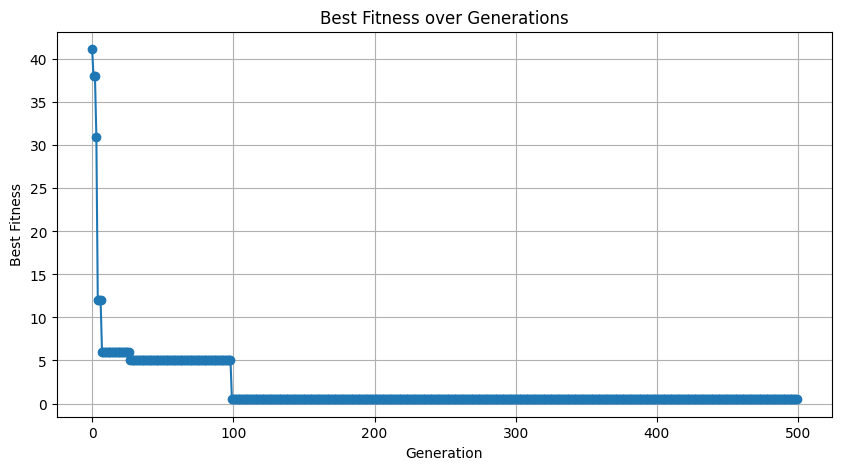

GA completed without finding the perfect solution.
Best solution:  ((75 * 25) / 6) - 50  =  262.5


In [10]:
evolved = evolve(numbers, 262, 500)[0]
print("Best solution: ", evolved[0], " = ", evolved[0].evaluate() )

In [11]:
# Define the sets of numbers
small_nums = [1,2,3,4,5,6,7,8,9,10]
large_nums = [25,50,75,100]


def select_numbers(small_nums, large_nums):
    # Choose 2 numbers from large_nums without replacement
    selected_large_nums = random.sample(large_nums, 2)

    # Choose 4 numbers from small_nums with the possibility of up to 2 repeats
    selected_small_nums = []
    for _ in range(4):
        num = random.choice(small_nums)
        # Check for repeats, ensure no more than 2 instances of any number
        if selected_small_nums.count(num) < 2:
            selected_small_nums.append(num)
        else:
            # Retry the choice if the number is already repeated twice
            while selected_small_nums.count(num) >= 2:
                num = random.choice(small_nums)
            selected_small_nums.append(num)

    # Combine the results into one list
    result_numbers = selected_large_nums + selected_small_nums
    return result_numbers

def calculate_a_target(numbers):
    while True:
        tree_target = random_tree(numbers.copy())
        target = tree_target.evaluate()

        # Check if target is an integer
        if isinstance(target, int) and target > 0:
            break

    return tree_target, target



def build_dataset(size, difficult=False, print_data=False):
  dataset = []
  for _ in range(size):
    numbers = select_numbers(small_nums, large_nums)
    if print_data:
      print("Selected Numbers:", numbers)

    if difficult: # a difficult target could potentially be unreachable
      target = random.randint(100, 999)
      if print_data:
        print("Target: ", target)
    else: # a non difficult target is definitely reachable but might be too easy to reach
      tree_target, target = calculate_a_target(numbers)
      if print_data:
        print("Target: ", tree_target , " = " , target)
    dataset.append((numbers, target))


  return dataset

In [12]:
def run_GA(dataset, max_gens):
  for game in dataset:

    numbers = game[0]
    target = game[1]
    print("\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n\nNew Game: Numbers = ", numbers , "Target = ", target)
    evolved = evolve(numbers, target, max_gens)[0]
    print("Best solution: ", evolved[0], " = ", evolved[0].evaluate() )
    print(f"{abs(evolved[0].evaluate()-target)} from the target")

In [13]:
def run_experiments(dataset1, rate=0.5, generations=100):
    avg_fitness_of_best_per_game = []
    avg_gen_to_find_per_game = []
    avg_fitness_per_gen_per_iter_per_game = []

    for game in dataset1:
        avg_fitness = 0
        avg_gen_to_find = 0
        avg_fitness_per_gen = []

        for i in range(10):
            numbers = game[0]
            target = game[1]
            population, best_solution, avg_fit_per_gen, gen_to_find = evolve(numbers, target, generations, mutation_rate=rate, plot=False, print_data=False)

            # Fill remaining generations with zeros if target reached early
            if len(avg_fit_per_gen) < generations:
                avg_fit_per_gen.extend([0] * (generations - len(avg_fit_per_gen)))

            avg_fitness_per_gen.append(avg_fit_per_gen)
            avg_fitness += best_solution.fitness
            avg_gen_to_find += gen_to_find

        avg_fitness /= len(dataset1)
        avg_gen_to_find /= len(dataset1)

        avg_fitness_of_best_per_game.append(avg_fitness)
        avg_gen_to_find_per_game.append(avg_gen_to_find)
        avg_fitness_per_gen_per_iter_per_game.append(avg_fitness_per_gen)

    return avg_fitness_of_best_per_game, avg_gen_to_find_per_game, avg_fitness_per_gen_per_iter_per_game



  # dataset2 = build_dataset(10, False)
  # run_GA(dataset2, 100)

## Experiment 1: EASY DATASET vs HARD DATASET FIXED MUTATION RATE 0.5

### Easy dataset

In [79]:
dataset1 = build_dataset(10, False)

# We run it 10 times per game to account for the randomness of the algorithm
# The first one has a length of 10 so the average fitness of the solution per game,
# The second one has a length of 10 so the average generations needed to find the solution per game,
# The third one is a matrix of 10x10x100 so [0][0] means the average (overall) fitness of the first game in the first iteration PER GENERATION.
# [0][1] means the average (overall) fitness of the first game in the second iteration PER GENERATION etc.
avg_fitness_of_solution_per_game, avg_gen_to_find_per_game, avg_fitness_per_gen_per_iter_per_game = run_experiments(dataset1)

GA completed without finding the perfect solution.
Solution found at generation 57
9 + (4 * (50 - 3))
GA stopped after finding the solution.
Solution found at generation 2
(4 * 50) + (3 / (8 - 9))
GA stopped after finding the solution.
Solution found at generation 39
(50 * 4) - (9 / 3)
GA stopped after finding the solution.
GA completed without finding the perfect solution.
Solution found at generation 17
((50 - 3) * 4) + 9
GA stopped after finding the solution.
Solution found at generation 86
(25 * 8) - ((3 + 9) / 4)
GA stopped after finding the solution.
Solution found at generation 33
(50 * 4) - 3
GA stopped after finding the solution.
Solution found at generation 58
(9 * 8) - (25 - (50 * 3))
GA stopped after finding the solution.
Solution found at generation 41
(50 * 4) - 3
GA stopped after finding the solution.
Solution found at generation 0
(100 - 8) + (1 - 10)
GA stopped after finding the solution.
Solution found at generation 0
75 + 8
GA stopped after finding the solution.
Solu

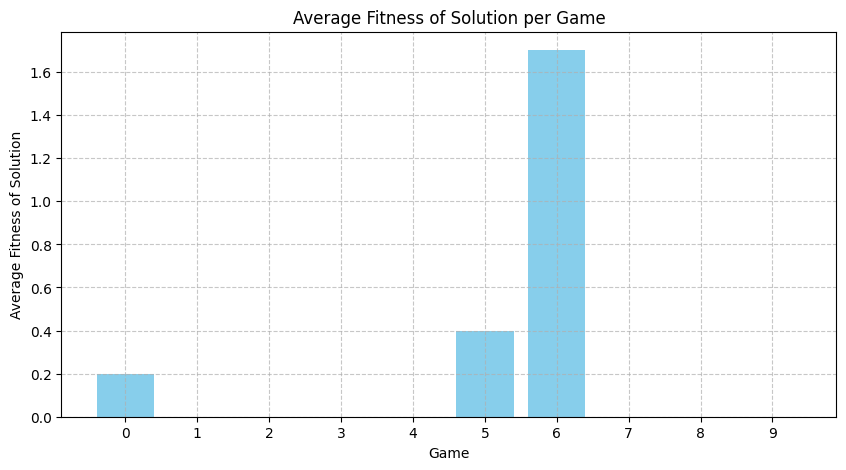

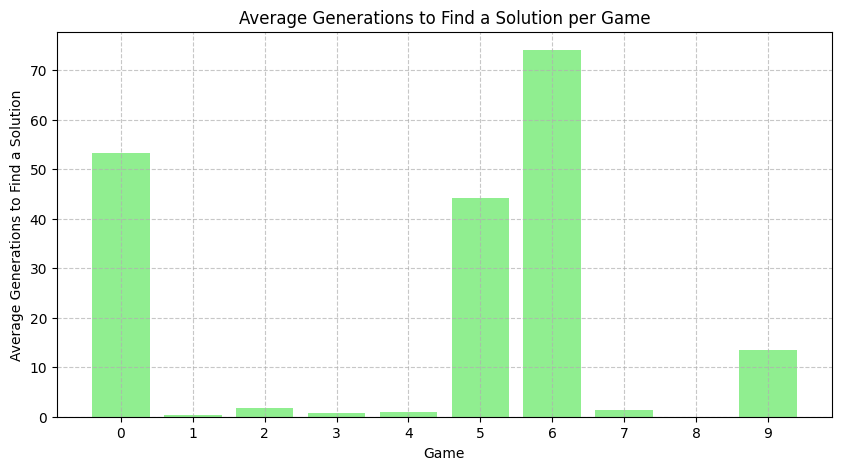

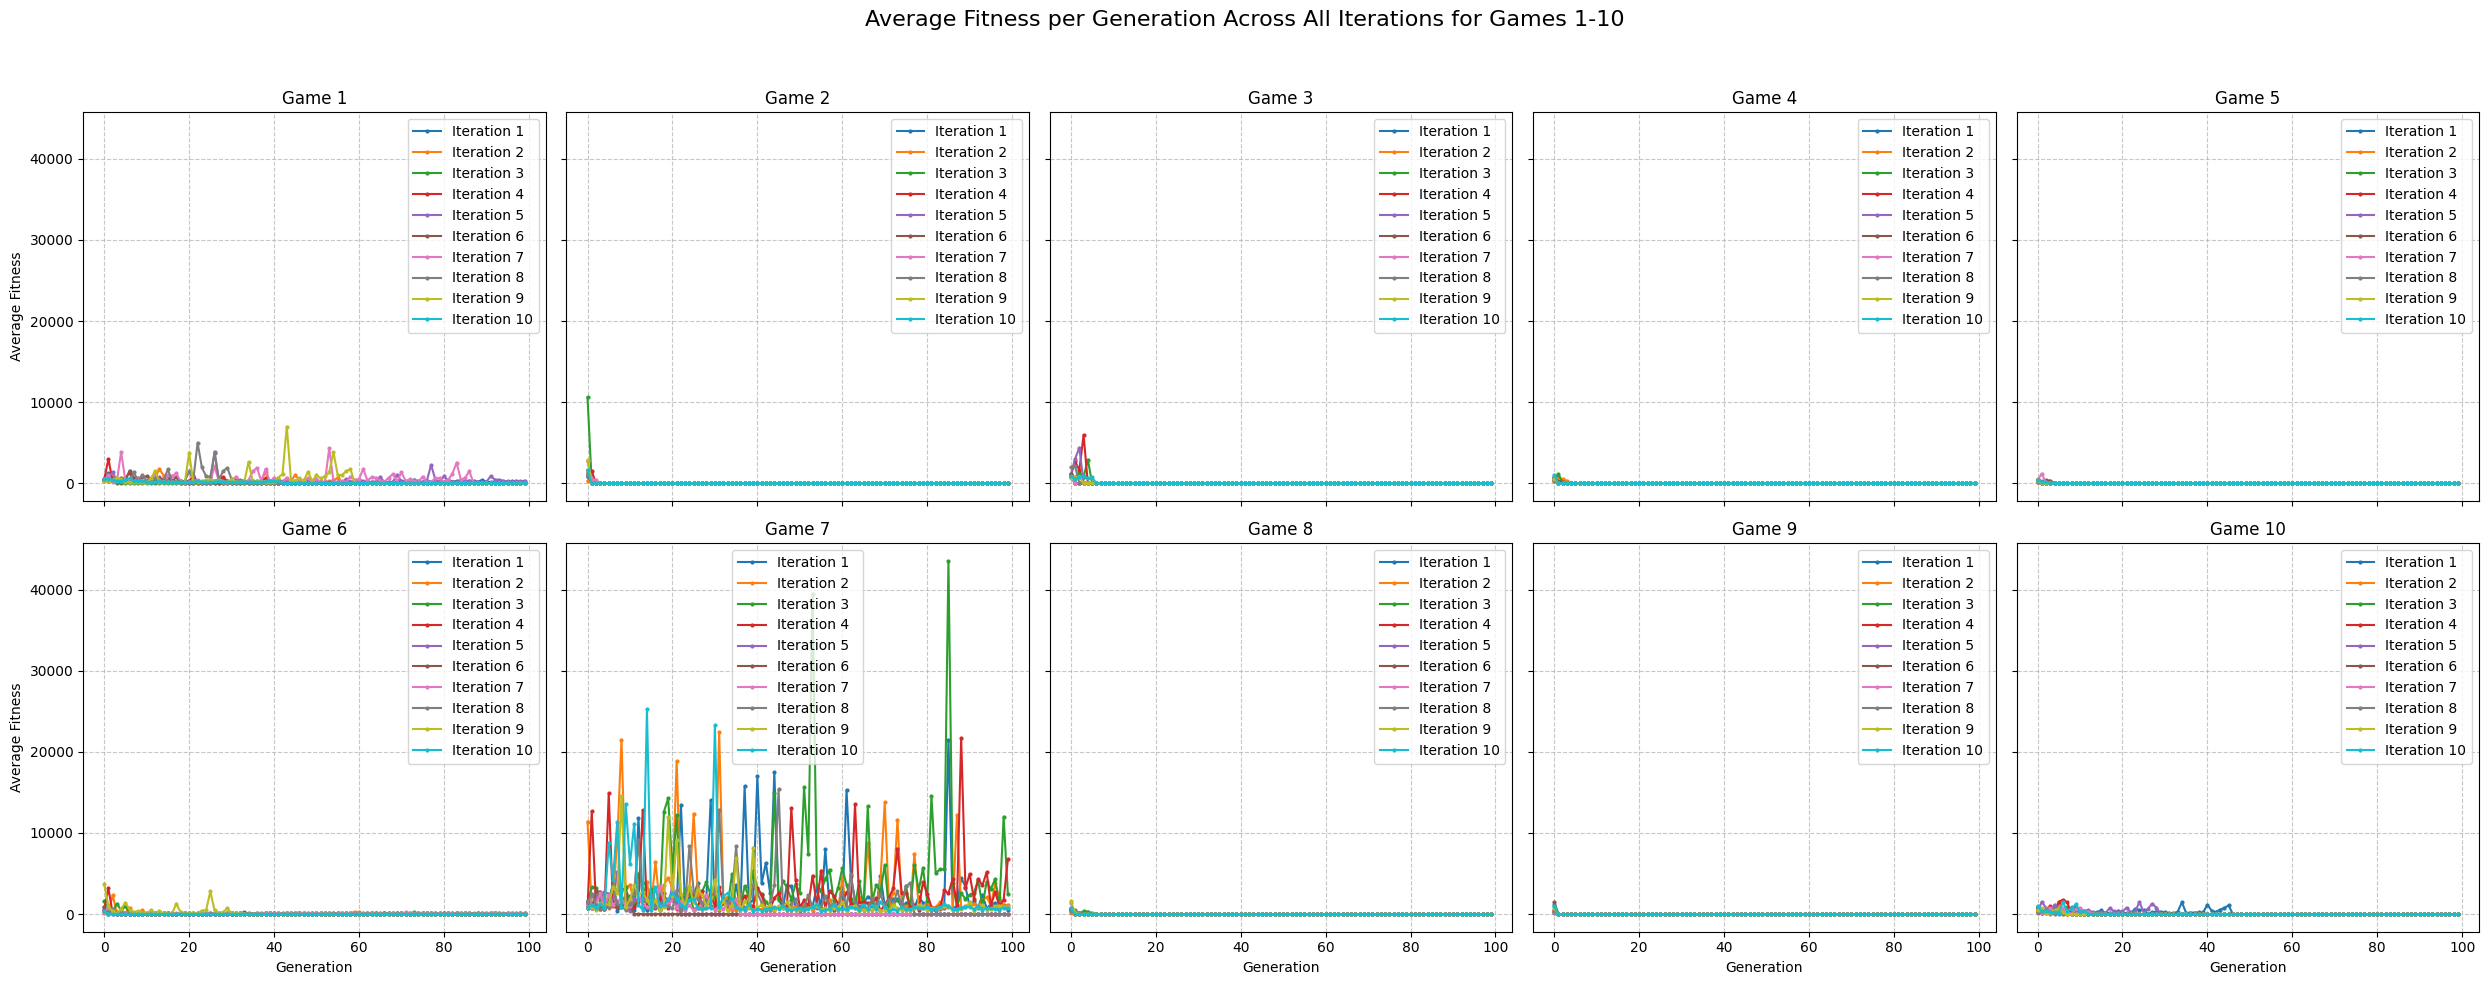

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns



# Plotting the average fitness of the solution per game
plt.figure(figsize=(10, 5))
plt.bar(range(len(avg_fitness_of_solution_per_game)), avg_fitness_of_solution_per_game, color='skyblue', label='Average Fitness')
plt.xlabel('Game')
plt.ylabel('Average Fitness of Solution')
plt.title('Average Fitness of Solution per Game')
plt.xticks(range(len(avg_fitness_of_solution_per_game)))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Plotting the average number of generations to find a solution per game
plt.figure(figsize=(10, 5))
plt.bar(range(len(avg_gen_to_find_per_game)), avg_gen_to_find_per_game, color='lightgreen')
plt.xlabel('Game')
plt.ylabel('Average Generations to Find a Solution')
plt.title('Average Generations to Find a Solution per Game')
plt.xticks(range(len(avg_gen_to_find_per_game)))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Indices for all 10 games
game_indices = range(10)

# Create subplots
fig, axs = plt.subplots(2, 5, figsize=(25, 10), sharex=True, sharey=True)

for ax, game_index in zip(axs.flat, game_indices):
    for iteration_index in range(len(avg_fitness_per_gen_per_iter_per_game[game_index])):
        fitness_data = avg_fitness_per_gen_per_iter_per_game[game_index][iteration_index]
        ax.plot(fitness_data, marker='o', linestyle='-', markersize=2, label=f'Iteration {iteration_index + 1}')
    ax.set_title(f'Game {game_index + 1}')
    ax.grid(True, linestyle='--', alpha=0.7)
    if game_index % 5 == 0:  # First column
        ax.set_ylabel('Average Fitness')
    if game_index >= 5:  # Second row
        ax.set_xlabel('Generation')
    ax.legend()

plt.suptitle('Average Fitness per Generation Across All Iterations for Games 1-10', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Hard dataset

In [82]:
dataset1 = build_dataset(10, True)

avg_fitness_of_solution_per_game, avg_gen_to_find_per_game, avg_fitness_per_gen_per_iter_per_game = run_experiments(dataset1)

Solution found at generation 19
((10 + 100) - (6 + 7)) * 8
GA stopped after finding the solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
Solution found at generation 12
6 + (7 * (10 + 100))
GA stopped after finding the solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
Solution found at generation 41
(100 * 8) - (25 + (6 - 7))
GA stopped after finding the solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
Solution found at generation 36
(((5 - 6) + 25) + 50) * 7
GA stopped after finding the solution.
GA completed without finding the perfect solution.
Solution found at generation 37
(7 * (25 + 50)) - 7
GA stopped after finding the solution.
Solution found at generation 0
(((6 + 50) - 7) + 25) * 7
GA stopped after finding the solution.
GA completed without

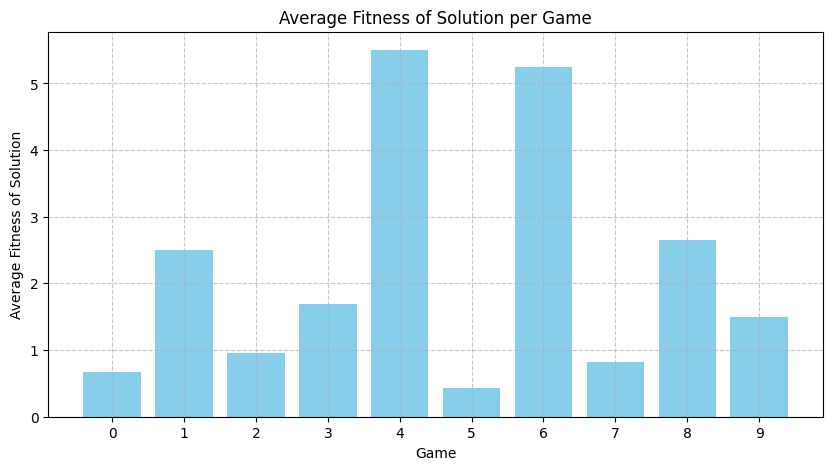

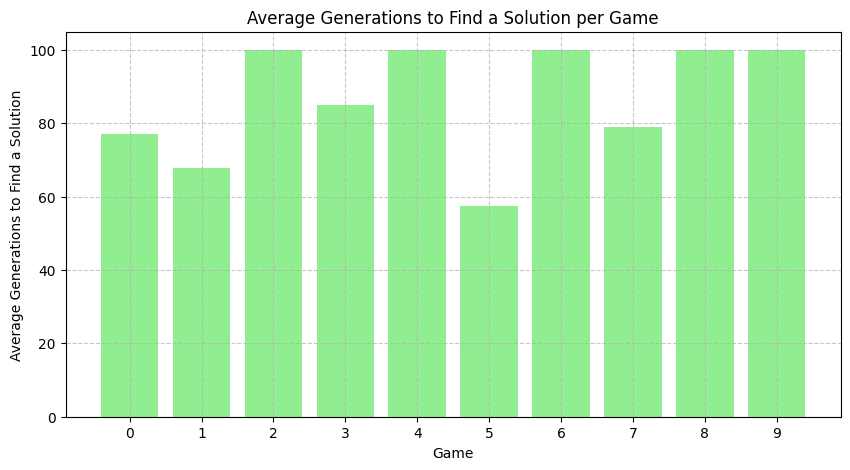

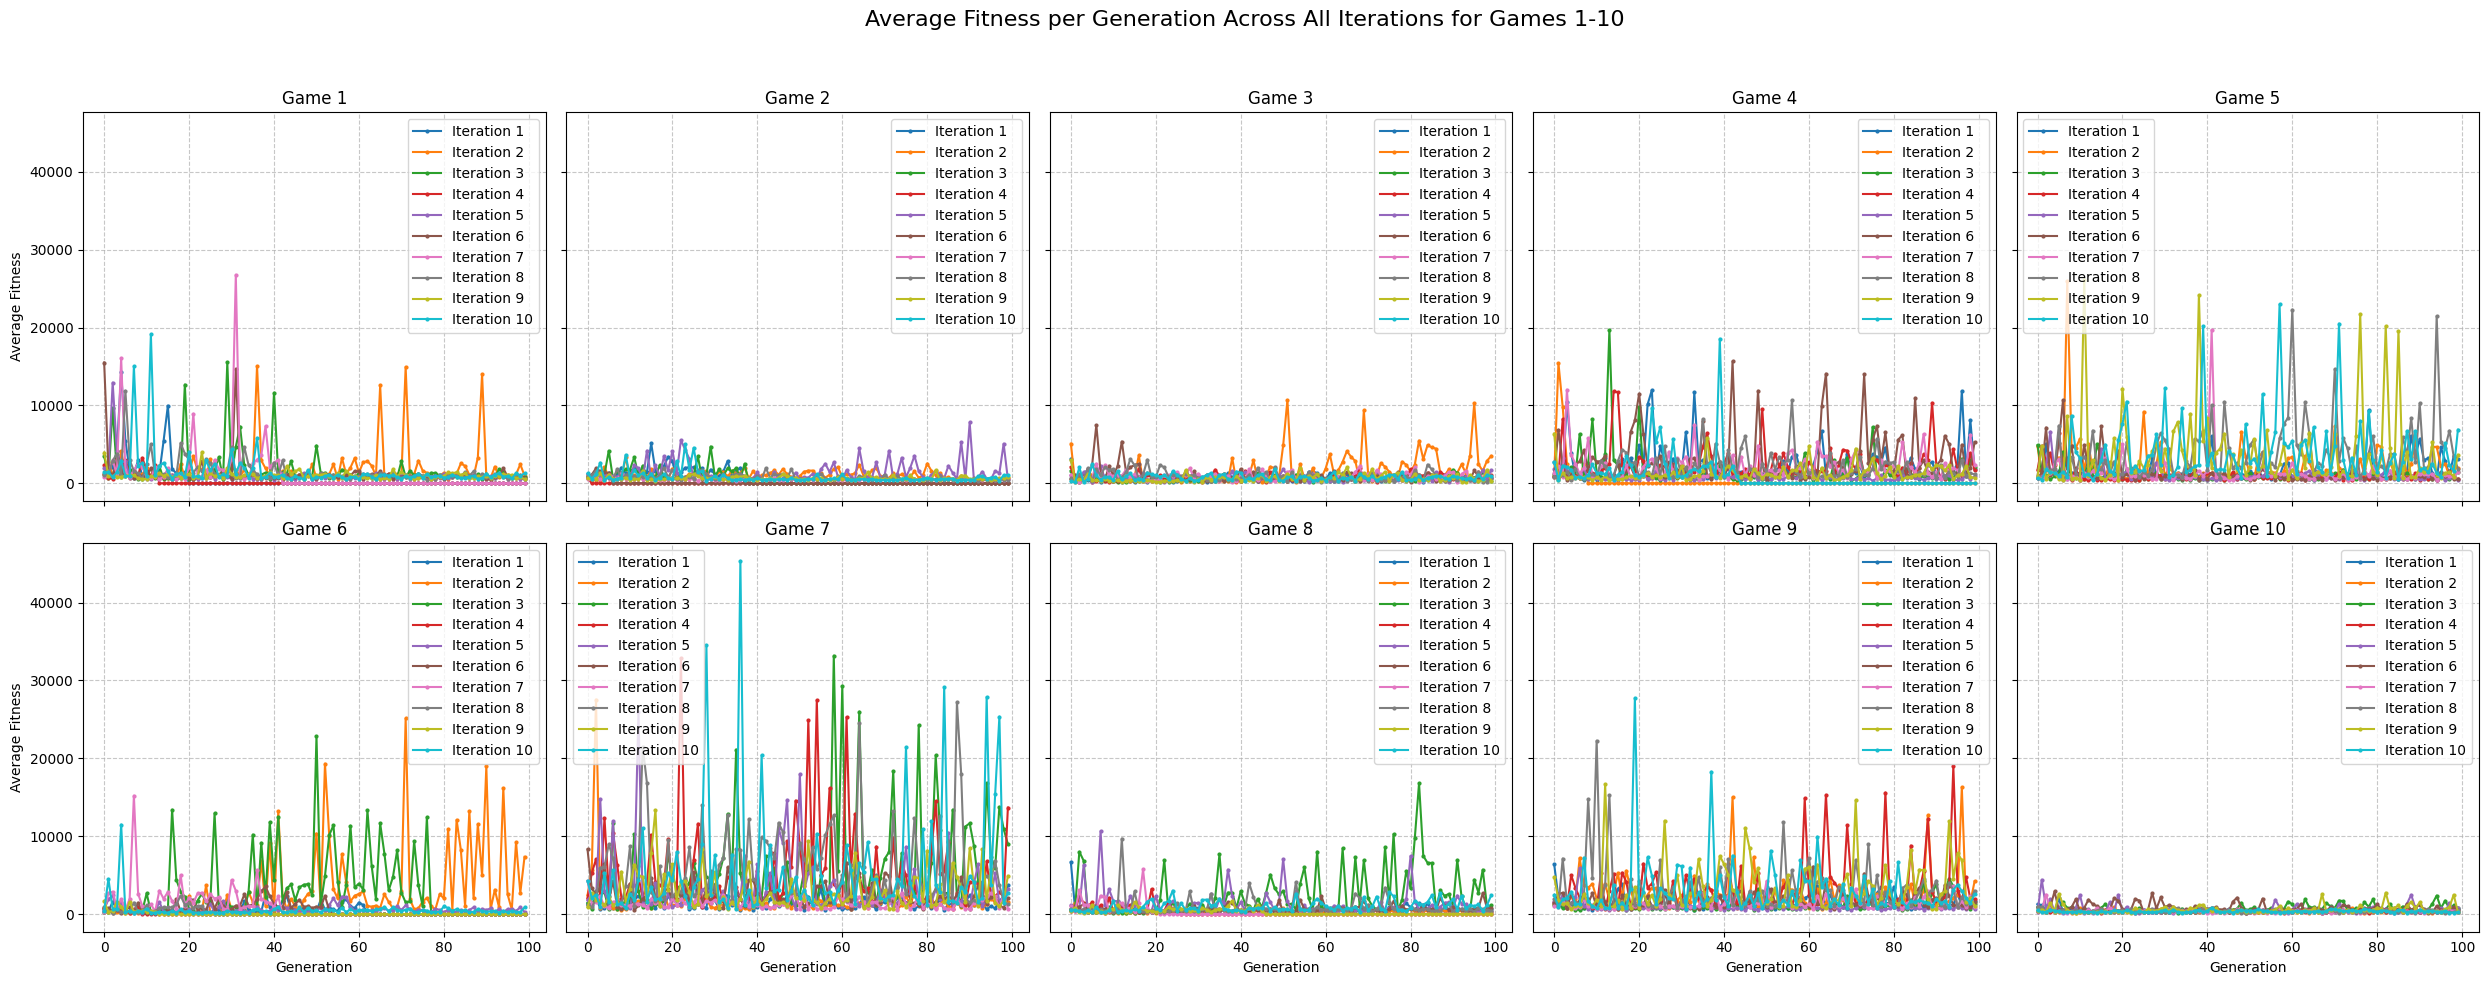

In [83]:

# Plotting the average fitness of the solution per game
plt.figure(figsize=(10, 5))
plt.bar(range(len(avg_fitness_of_solution_per_game)), avg_fitness_of_solution_per_game, color='skyblue', label='Average Fitness')
plt.xlabel('Game')
plt.ylabel('Average Fitness of Solution')
plt.title('Average Fitness of Solution per Game')
plt.xticks(range(len(avg_fitness_of_solution_per_game)))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Plotting the average number of generations to find a solution per game
plt.figure(figsize=(10, 5))
plt.bar(range(len(avg_gen_to_find_per_game)), avg_gen_to_find_per_game, color='lightgreen')
plt.xlabel('Game')
plt.ylabel('Average Generations to Find a Solution')
plt.title('Average Generations to Find a Solution per Game')
plt.xticks(range(len(avg_gen_to_find_per_game)))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Indices for all 10 games
game_indices = range(10)

# Create subplots
fig, axs = plt.subplots(2, 5, figsize=(25, 10), sharex=True, sharey=True)

for ax, game_index in zip(axs.flat, game_indices):
    for iteration_index in range(len(avg_fitness_per_gen_per_iter_per_game[game_index])):
        fitness_data = avg_fitness_per_gen_per_iter_per_game[game_index][iteration_index]
        ax.plot(fitness_data, marker='o', linestyle='-', markersize=2, label=f'Iteration {iteration_index + 1}')
    ax.set_title(f'Game {game_index + 1}')
    ax.grid(True, linestyle='--', alpha=0.7)
    if game_index % 5 == 0:  # First column
        ax.set_ylabel('Average Fitness')
    if game_index >= 5:  # Second row
        ax.set_xlabel('Generation')
    ax.legend()

plt.suptitle('Average Fitness per Generation Across All Iterations for Games 1-10', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Experiment 2: EASY DATASET VARIED MUTATION RATE

In [84]:
#
mutation_rates = [0.1, 0.3, 0.5, 0.7, 0.9]

dataset1 = build_dataset(10, False)
mut_rate_dict_easy = {}

for rate in mutation_rates:
    avg_fitness_of_solution_per_game, avg_gen_to_find_per_game, avg_fitness_per_gen_per_iter_per_game = run_experiments(dataset1, rate)
    mut_rate_dict_easy[rate] = (avg_fitness_of_solution_per_game, avg_gen_to_find_per_game, avg_fitness_per_gen_per_iter_per_game)

Solution found at generation 34
50 - 1
GA stopped after finding the solution.
Solution found at generation 0
(50 - 2) + 1
GA stopped after finding the solution.
GA completed without finding the perfect solution.
Solution found at generation 11
50 - 1
GA stopped after finding the solution.
GA completed without finding the perfect solution.
Solution found at generation 0
50 - ((5 + 1) - 5)
GA stopped after finding the solution.
Solution found at generation 6
50 - 1
GA stopped after finding the solution.
Solution found at generation 0
(50 - 5) + (5 - 1)
GA stopped after finding the solution.
Solution found at generation 26
50 - (2 - 1)
GA stopped after finding the solution.
Solution found at generation 2
50 - 1
GA stopped after finding the solution.
Solution found at generation 85
25 - (((9 + 9) / 6) + 1)
GA stopped after finding the solution.
Solution found at generation 38
9 - ((6 - 9) * (100 / 25))
GA stopped after finding the solution.
GA completed without finding the perfect solution

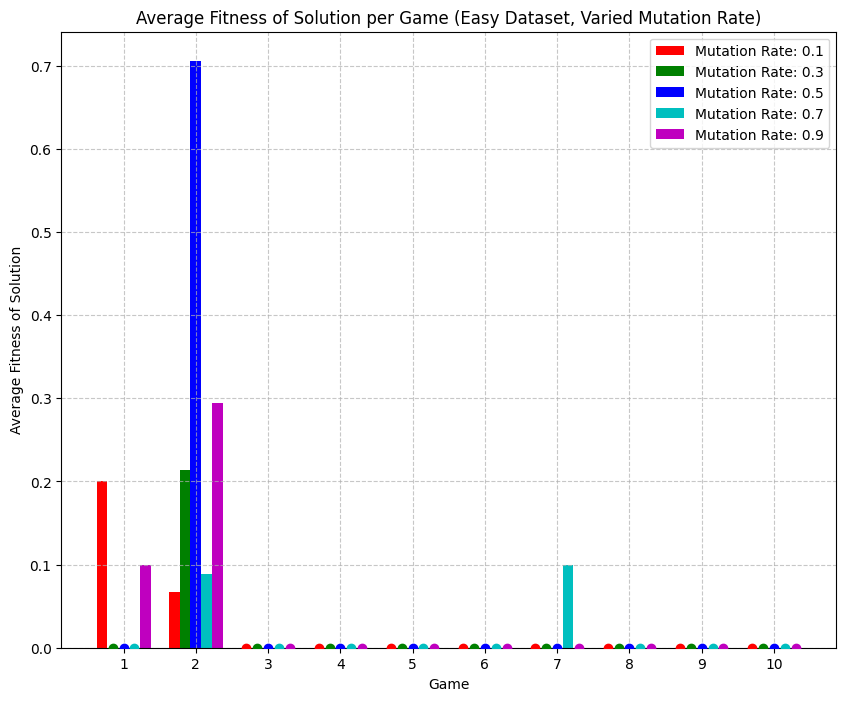

In [86]:
import numpy as np
# Plotting the average fitness of the solution per game (bar plot with dots for zero values)
plt.figure(figsize=(10, 8))
x = np.arange(1, len(dataset1) + 1)  # Assumes 10 games as per dataset1
width = 0.15
colors = ['r', 'g', 'b', 'c', 'm']

for i, (rate, data) in enumerate(mut_rate_dict_easy.items()):
    avg_fitness_of_solution_per_game, _, _ = data
    bars = plt.bar(x + i * width, avg_fitness_of_solution_per_game, width=width, label=f'Mutation Rate: {rate}', color=colors[i])

    # Plot dots for zero values in the same color as the bars
    for j, value in enumerate(avg_fitness_of_solution_per_game):
        if value == 0:
            plt.scatter(x[j] + i * width, 0, color=colors[i], zorder=5)

plt.xlabel('Game')
plt.ylabel('Average Fitness of Solution')
plt.title('Average Fitness of Solution per Game (Easy Dataset, Varied Mutation Rate)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x + width * (len(mutation_rates) - 1) / 2, range(1, len(dataset1) + 1))
plt.show()

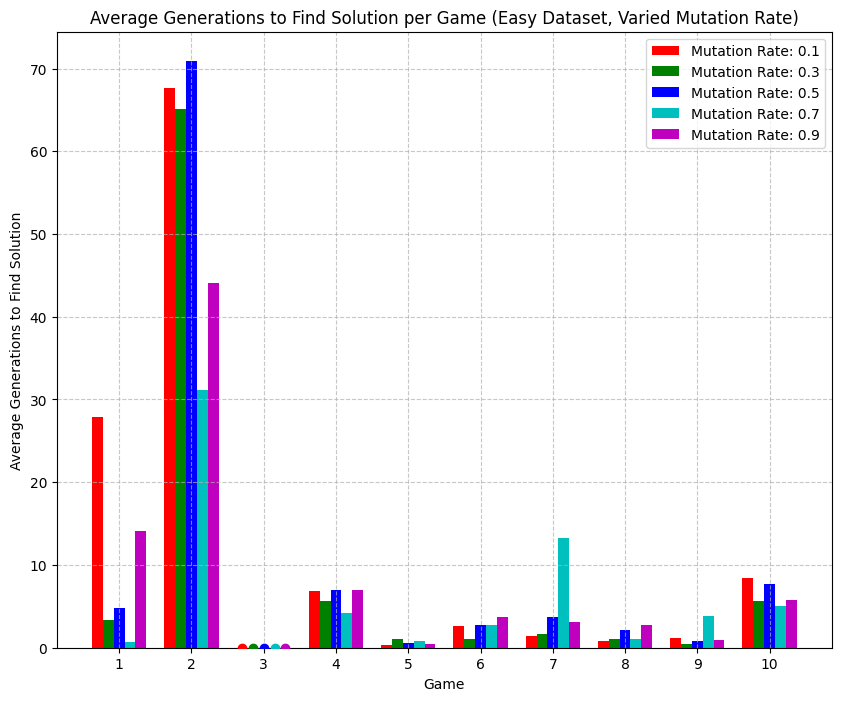

In [87]:
# Plotting the average fitness of the solution per game (bar plot with dots for zero values)
plt.figure(figsize=(10, 8))  # Set the figure size to be square
x = np.arange(1, len(dataset1) + 1)  # Assumes 10 games as per dataset1
width = 0.15
colors = ['r', 'g', 'b', 'c', 'm']

for i, (rate, data) in enumerate(mut_rate_dict_easy.items()):
    _, avg_gen_to_find_per_game, _ = data
    bars = plt.bar(x + i * width, avg_gen_to_find_per_game, width=width, label=f'Mutation Rate: {rate}', color=colors[i])

    # Plot dots for zero values in the same color as the bars
    for j, value in enumerate(avg_gen_to_find_per_game):
        if value == 0:
            plt.scatter(x[j] + i * width, 0, color=colors[i], zorder=5)

plt.xlabel('Game')
plt.ylabel('Average Generations to Find Solution')
plt.title('Average Generations to Find Solution per Game (Easy Dataset, Varied Mutation Rate)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x + width * (len(mutation_rates) - 1) / 2, range(1, len(dataset1) + 1))
plt.show()

## Experiment 3: HARD DATASET VARIED MUTATION RATE

In [89]:
#
mutation_rates = [0.1, 0.3, 0.5, 0.7, 0.9]

dataset1 = build_dataset(10, True)
mut_rate_dict_hard = {}

for rate in mutation_rates:
    avg_fitness_of_solution_per_game, avg_gen_to_find_per_game, avg_fitness_per_gen_per_iter_per_game = run_experiments(dataset1, rate)
    mut_rate_dict_hard[rate] = (avg_fitness_of_solution_per_game, avg_gen_to_find_per_game, avg_fitness_per_gen_per_iter_per_game)

Solution found at generation 18
(50 / (7 + 8)) * (75 + 3)
GA stopped after finding the solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
Solution found at generation 16
(7 * (50 - 1)) - (8 + 75)
GA stopped after finding the solution.
Solution found at generation 13
(7 + (50 + 8)) * (3 + 1)
GA stopped after finding the solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
Solution found at generation 2
((50 * 3) + 8) + (1 - 2)
GA stopped after finding the solution.
Solution found at generation 65
((3 * 50) + (8 + 1)) - 2
GA stopped after finding the solution.
Solution found at generation 57
(2 * (3 + 75)) + 1
GA stopped after finding the solution.
Solution found at generation 46
(2 * (75 + 3)) + 1
GA stopped after find

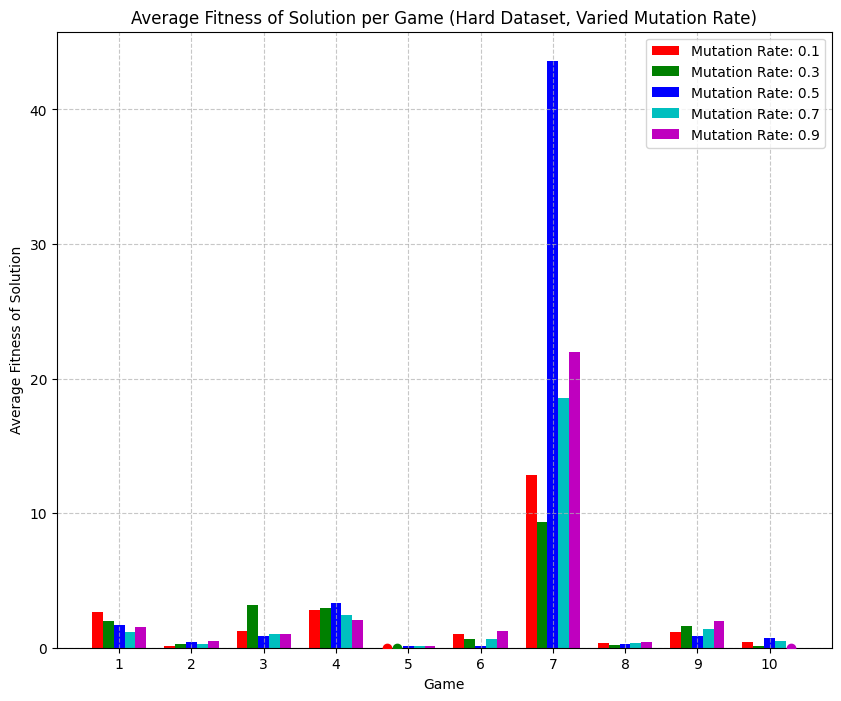

In [90]:
# Plotting the average fitness of the solution per game (bar plot with dots for zero values)
plt.figure(figsize=(10, 8))
x = np.arange(1, len(dataset1) + 1)  # Assumes 10 games as per dataset1
width = 0.15
colors = ['r', 'g', 'b', 'c', 'm']

for i, (rate, data) in enumerate(mut_rate_dict_hard.items()):
    avg_fitness_of_solution_per_game, _, _ = data
    bars = plt.bar(x + i * width, avg_fitness_of_solution_per_game, width=width, label=f'Mutation Rate: {rate}', color=colors[i])

    # Plot dots for zero values in the same color as the bars
    for j, value in enumerate(avg_fitness_of_solution_per_game):
        if value == 0:
            plt.scatter(x[j] + i * width, 0, color=colors[i], zorder=5)

plt.xlabel('Game')
plt.ylabel('Average Fitness of Solution')
plt.title('Average Fitness of Solution per Game (Hard Dataset, Varied Mutation Rate)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x + width * (len(mutation_rates) - 1) / 2, range(1, len(dataset1) + 1))
plt.show()

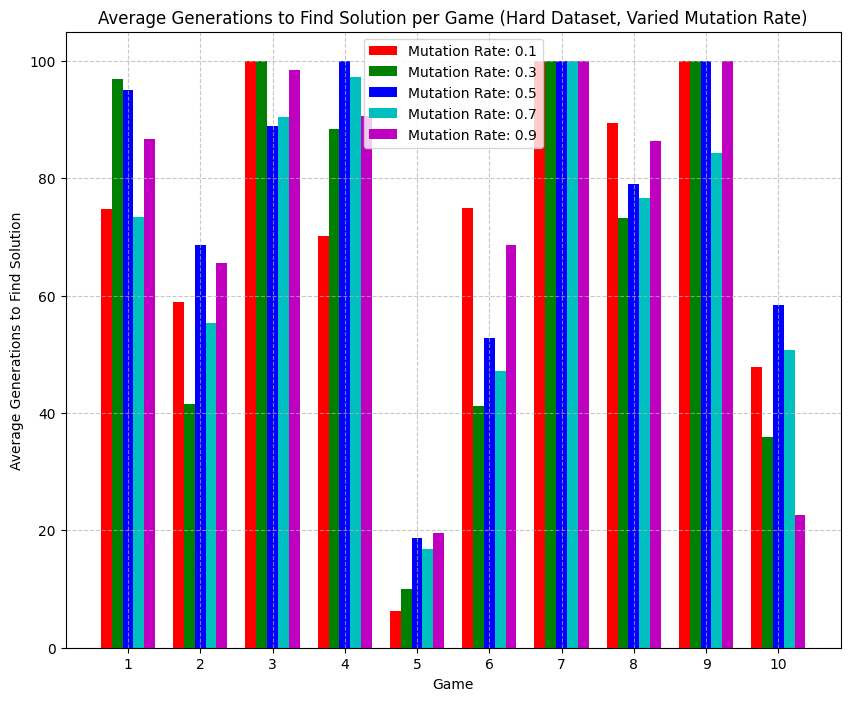

In [91]:
# Plotting the average fitness of the solution per game (bar plot with dots for zero values)
plt.figure(figsize=(10, 8))  # Set the figure size to be square
x = np.arange(1, len(dataset1) + 1)  # Assumes 10 games as per dataset1
width = 0.15
colors = ['r', 'g', 'b', 'c', 'm']

for i, (rate, data) in enumerate(mut_rate_dict_hard.items()):
    _, avg_gen_to_find_per_game, _ = data
    bars = plt.bar(x + i * width, avg_gen_to_find_per_game, width=width, label=f'Mutation Rate: {rate}', color=colors[i])

    # Plot dots for zero values in the same color as the bars
    for j, value in enumerate(avg_gen_to_find_per_game):
        if value == 0:
            plt.scatter(x[j] + i * width, 0, color=colors[i], zorder=5)

plt.xlabel('Game')
plt.ylabel('Average Generations to Find Solution')
plt.title('Average Generations to Find Solution per Game (Hard Dataset, Varied Mutation Rate)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x + width * (len(mutation_rates) - 1) / 2, range(1, len(dataset1) + 1))
plt.show()

## Experiment 4: HARD DATASED VARIED GENERATION LIMIT

In [14]:
rate = 0.5
generations = [100, 200, 300, 400, 500]

dataset1 = build_dataset(10, True)
gen_dict_hard = {}

for gen in generations:
    avg_fitness_of_solution_per_game, avg_gen_to_find_per_game, avg_fitness_per_gen_per_iter_per_game = run_experiments(dataset1, rate, gen)
    gen_dict_hard[gen] = (avg_fitness_of_solution_per_game, avg_gen_to_find_per_game, avg_fitness_per_gen_per_iter_per_game)

GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
Solution found at generation 8
((50 + 75) * 7) - (5 - 9)
GA stopped after finding the solution.
GA completed without finding the perfect solution.
GA completed without finding the perfect solution.
Solution found at generation 17
8 * (7 + (75 + 6))
GA stopped after finding the solution.
GA completed without finding the perfect solution.
Solution found at generation 35
8 * (7 + (75 + 6))
GA stopped after finding the solution.
Solution found at generation 9
8 * (75 + (6 + 7))
GA stopped after finding the solution.
Solution found at gener

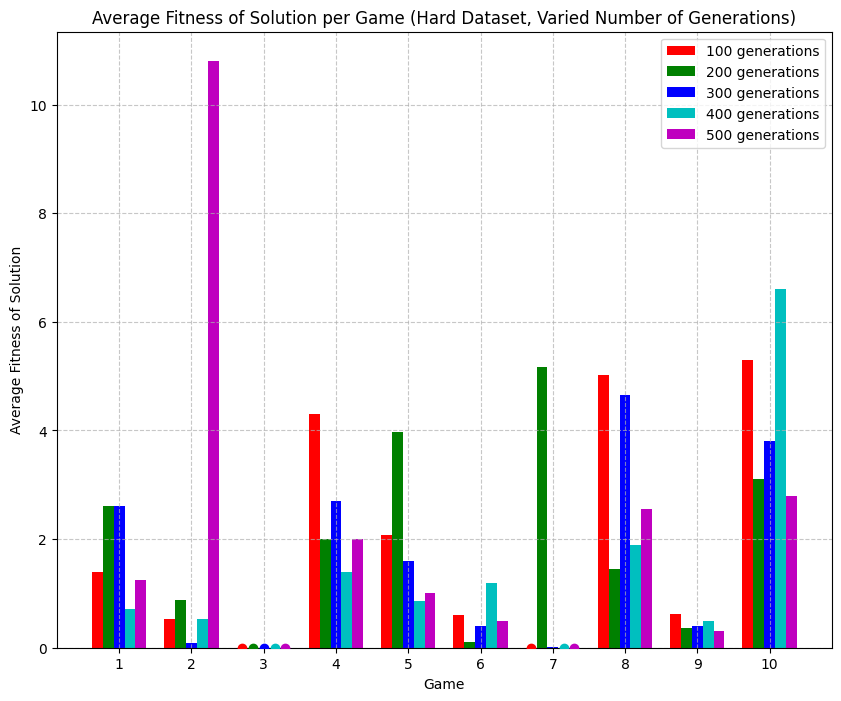

In [15]:
import numpy as np

# Plotting the average fitness of the solution per game (bar plot with dots for zero values)
plt.figure(figsize=(10, 8))
x = np.arange(1, len(dataset1) + 1)  # Assumes 10 games as per dataset1
width = 0.15
colors = ['r', 'g', 'b', 'c', 'm']

for i, (gen, data) in enumerate(gen_dict_hard.items()):
    avg_fitness_of_solution_per_game, _, _ = data
    bars = plt.bar(x + i * width, avg_fitness_of_solution_per_game, width=width, label=f'{gen} generations', color=colors[i])

    # Plot dots for zero values in the same color as the bars
    for j, value in enumerate(avg_fitness_of_solution_per_game):
        if value == 0:
            plt.scatter(x[j] + i * width, 0, color=colors[i], zorder=5)

plt.xlabel('Game')
plt.ylabel('Average Fitness of Solution')
plt.title('Average Fitness of Solution per Game (Hard Dataset, Varied Number of Generations)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x + width * (len(generations) - 1) / 2, range(1, len(dataset1) + 1))
plt.show()

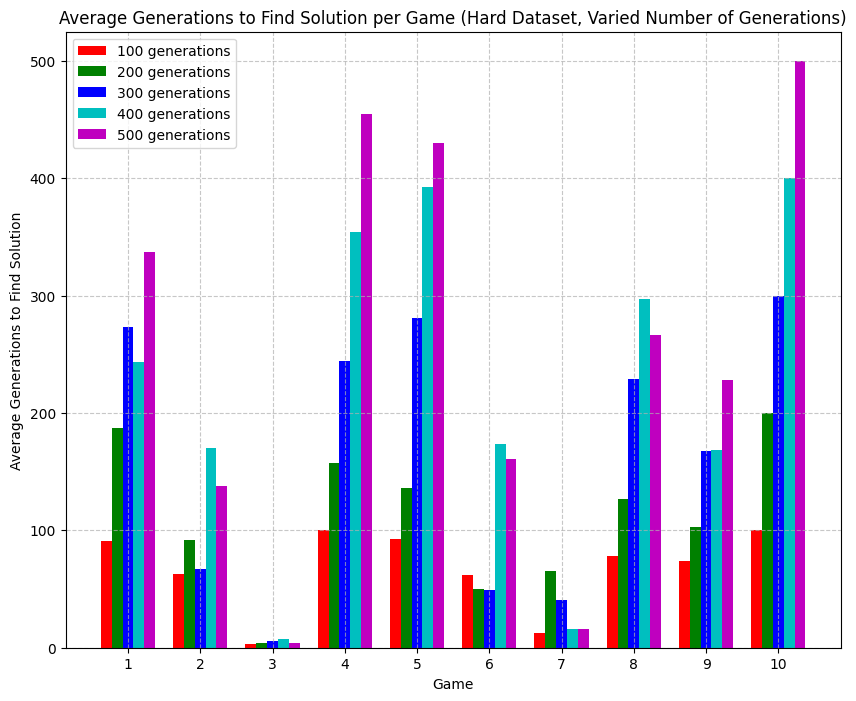

In [16]:
# Plotting the average fitness of the solution per game (bar plot with dots for zero values)
plt.figure(figsize=(10, 8))  # Set the figure size to be square
x = np.arange(1, len(dataset1) + 1)  # Assumes 10 games as per dataset1
width = 0.15
colors = ['r', 'g', 'b', 'c', 'm']

for i, (gen, data) in enumerate(gen_dict_hard.items()):
    _, avg_gen_to_find_per_game, _ = data
    bars = plt.bar(x + i * width, avg_gen_to_find_per_game, width=width, label=f'{gen} generations', color=colors[i])

    # Plot dots for zero values in the same color as the bars
    for j, value in enumerate(avg_gen_to_find_per_game):
        if value == 0:
            plt.scatter(x[j] + i * width, 0, color=colors[i], zorder=5)

plt.xlabel('Game')
plt.ylabel('Average Generations to Find Solution')
plt.title('Average Generations to Find Solution per Game (Hard Dataset, Varied Number of Generations)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x + width * (len(generations) - 1) / 2, range(1, len(dataset1) + 1))
plt.show()